<a href="https://colab.research.google.com/github/RichardLiuCoding/Publications/blob/main/BO_simulation_for_automated_exploration_of_combi_library.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Notebook by Richard (Yu) Liu, 2025, https://scholar.google.com/citations?user=f8aS9_0AAAAJ&hl=en
- SmBFO sample by Rohit Pant (https://scholar.google.com/citations?user=7lhXiEIAAAAJ&hl=en&oi=ao) and Ichiro Takeuchi (https://scholar.google.com/citations?user=OB9Pab8AAAAJ&hl=en&oi=ao)

# Import packages

In [1]:
!pip install botorch
!pip install gpytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import torch

from botorch.fit import fit_gpytorch_mll
from botorch.utils import standardize

from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement, UpperConfidenceBound, LogExpectedImprovement
from gpytorch.distributions import MultivariateNormal
import gpytorch

import warnings
warnings.filterwarnings('ignore')

In [4]:
from botorch.optim import optimize_acqf

from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.priors import GammaPrior, LogNormalPrior, HalfNormalPrior
from gpytorch.likelihoods import GaussianLikelihood


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from scipy.interpolate import interp1d

In [6]:
# Define the custom BO function to accept priors

# Create a GP model with the custom kernel
class CustomSingleTaskGP(SingleTaskGP):
    def __init__(self, train_X, train_Y, kernel):
        likelihood = GaussianLikelihood()
        super().__init__(train_X, train_Y, likelihood=likelihood, covar_module=kernel)

# Load full-grid data

In [7]:
!gdown 1PlWD3jcUzZWdK9qu_K1--XA4s7a7UbYB

Downloading...
From: https://drive.google.com/uc?id=1PlWD3jcUzZWdK9qu_K1--XA4s7a7UbYB
To: /content/loop_height.txt
100% 1.00k/1.00k [00:00<00:00, 5.83MB/s]


This is a 20-points grid search measured on Sm-BFO sample presented in the manuscript. Here we load the mean and standard variation of the measured loop height at different locations.

We will use the interpolated function to generate new data points in the active learning simulation below.

Text(0, 0.5, 'Loop Height (a.u.)')

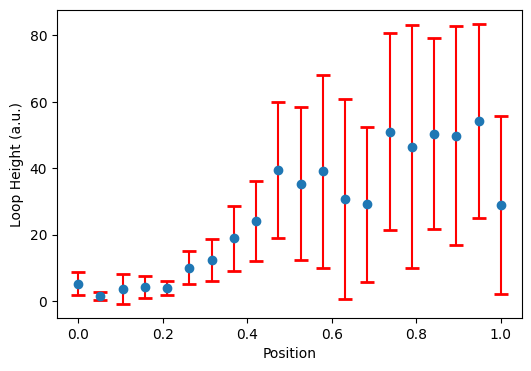

In [8]:
# Interpolate the amplitude mean function

amp_mean, amp_std = np.loadtxt('loop_height.txt')

f_interpolate = interp1d(np.linspace(0, 1, num=20), amp_mean, kind='cubic')
noise_interpolate = interp1d(np.linspace(0, 1, num=20), amp_std, kind='cubic')


# Visualize the grid data

plt.figure(figsize=[6,4])
plt.errorbar(np.linspace(0, 1, num=20), amp_mean, yerr=amp_std, fmt='o', capsize=5, capthick=2, ecolor='red',
            label='Loop height')
plt.xlabel('Position')
plt.ylabel('Loop Height (a.u.)')

# nBO simulation based on the full-grid data

Here x is the location/composition, y is the measured loop height, and yvar is the measured variation (noise) of the loop height.

We're using 5 initial seeding points + 20 exploration steps in this simulation.

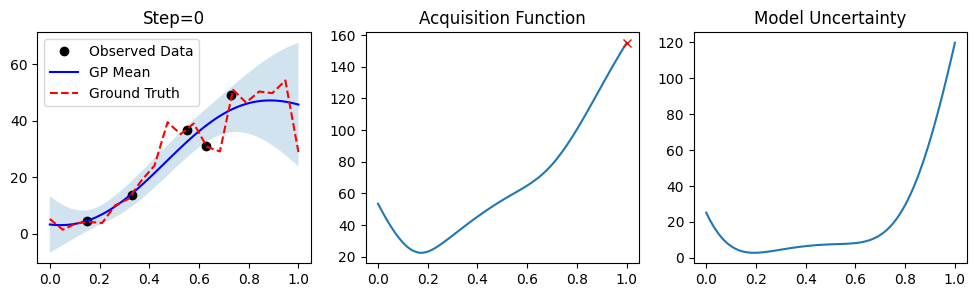

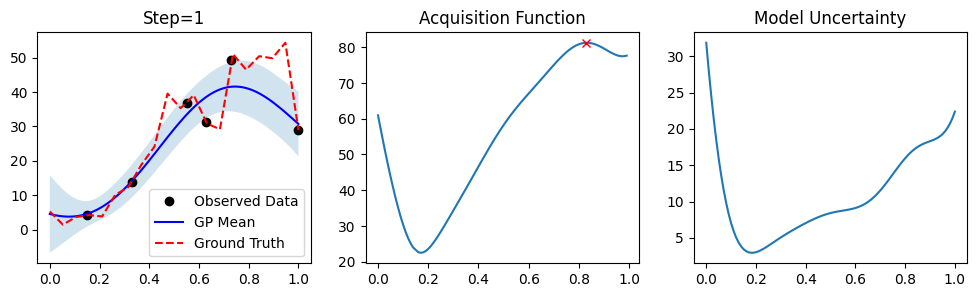

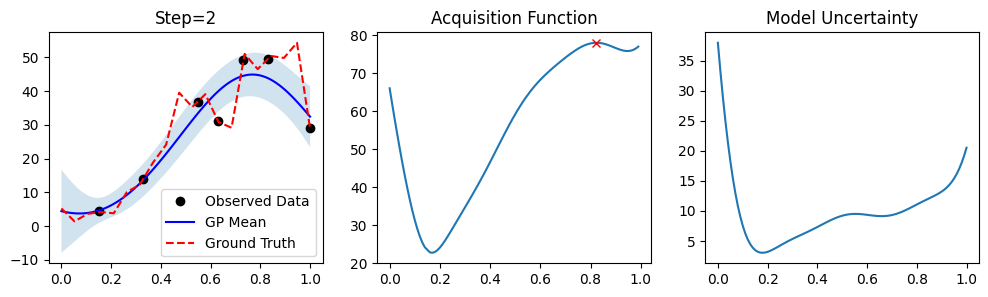

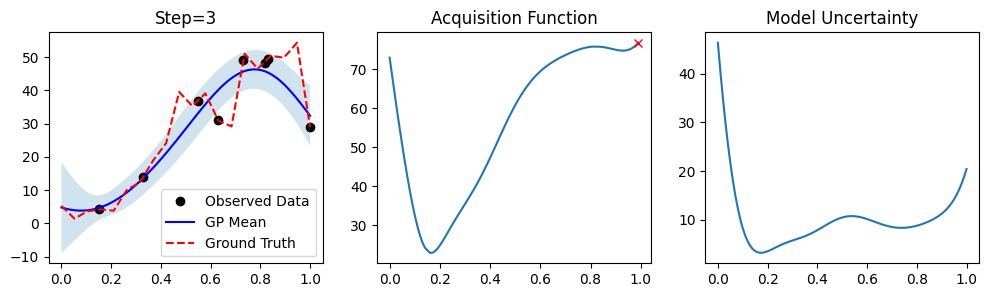

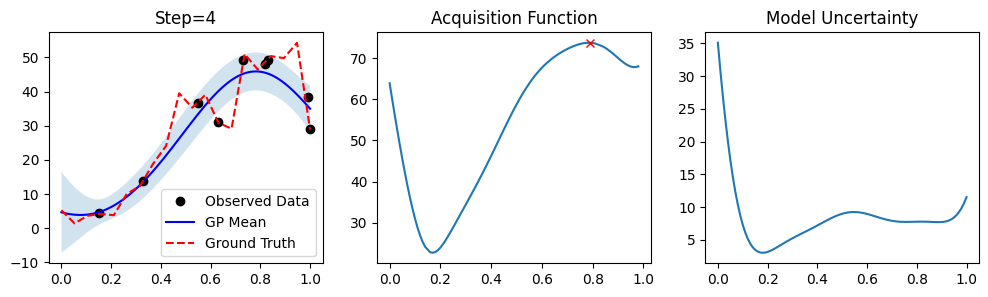

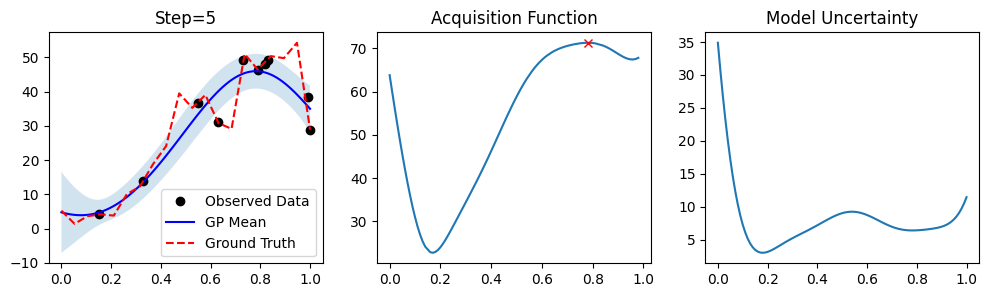

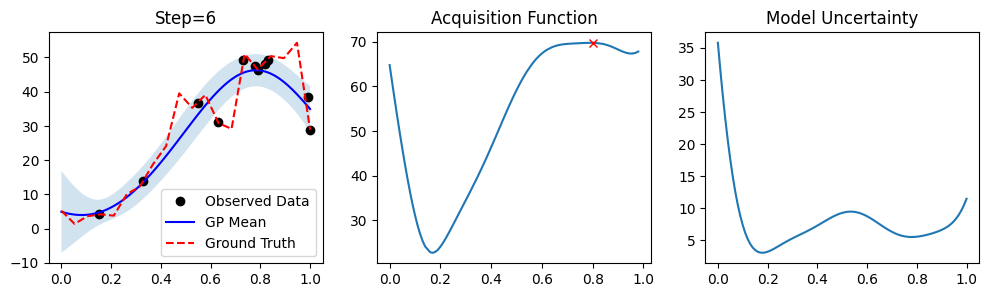

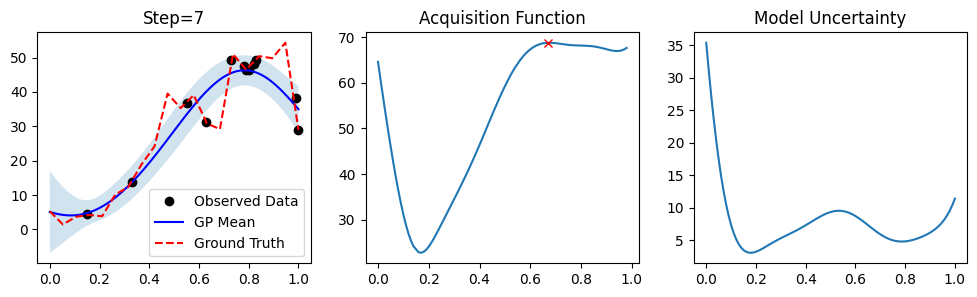

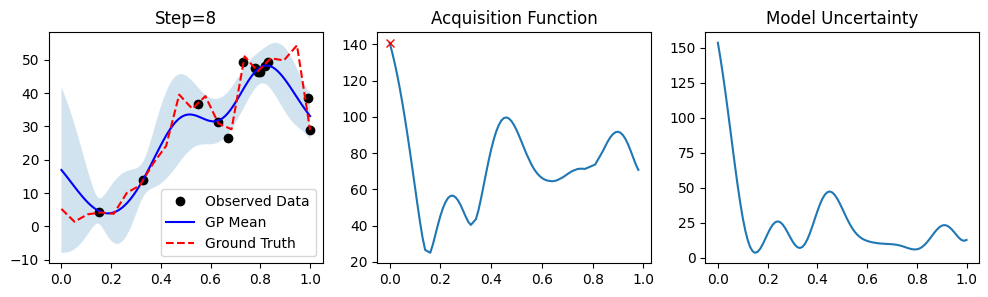

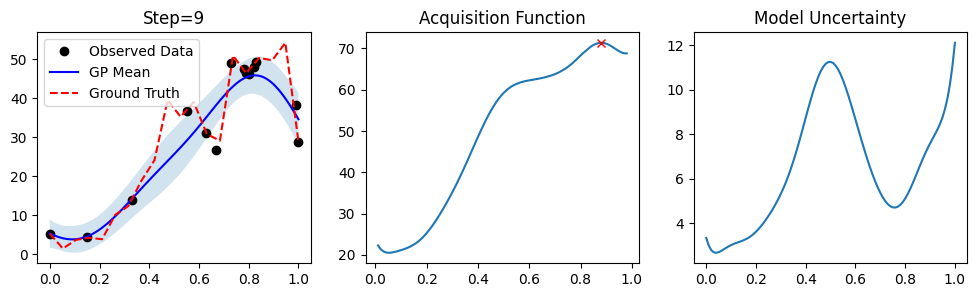

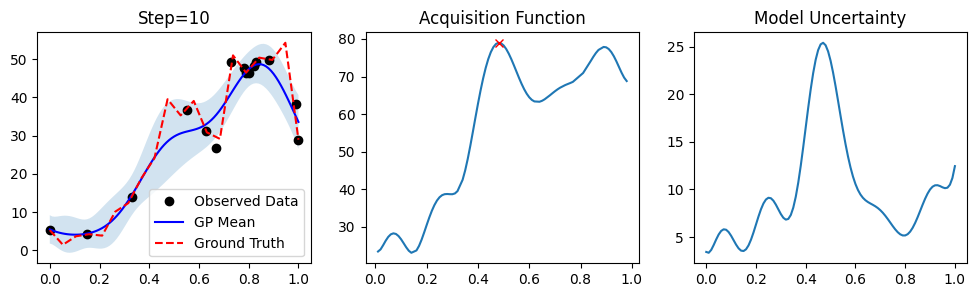

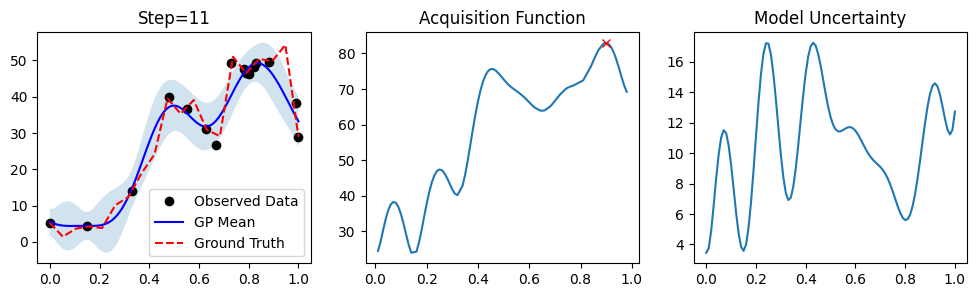

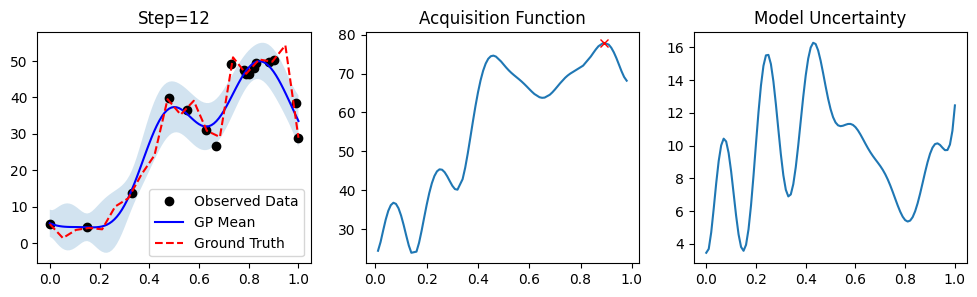

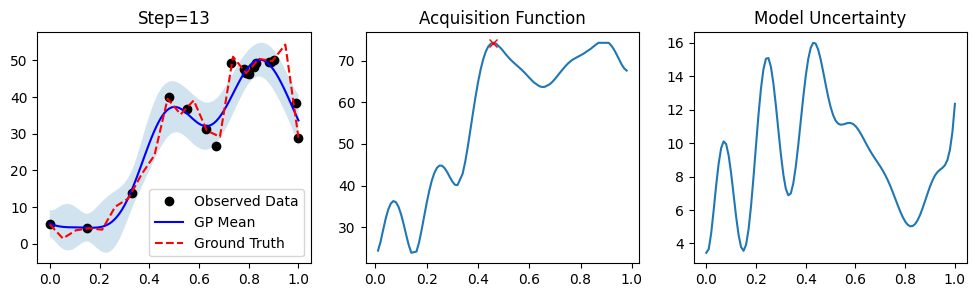

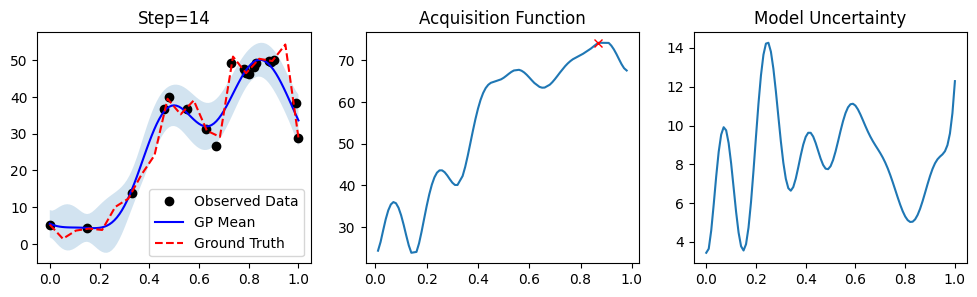

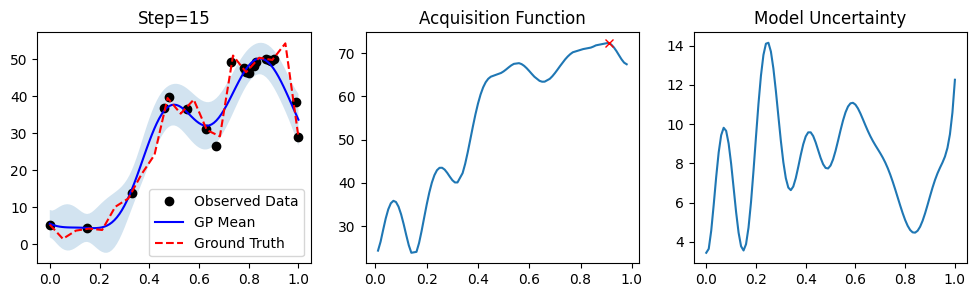

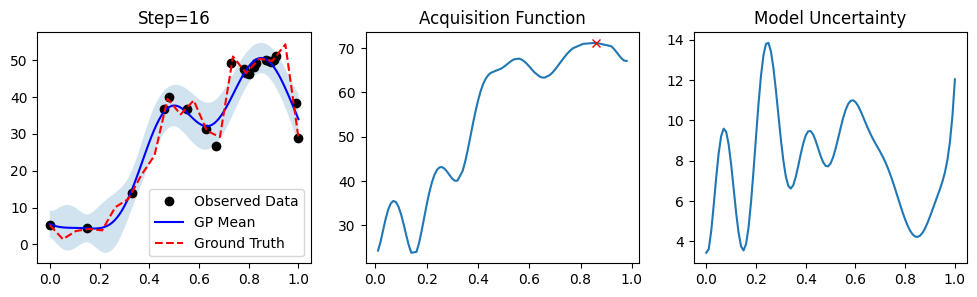

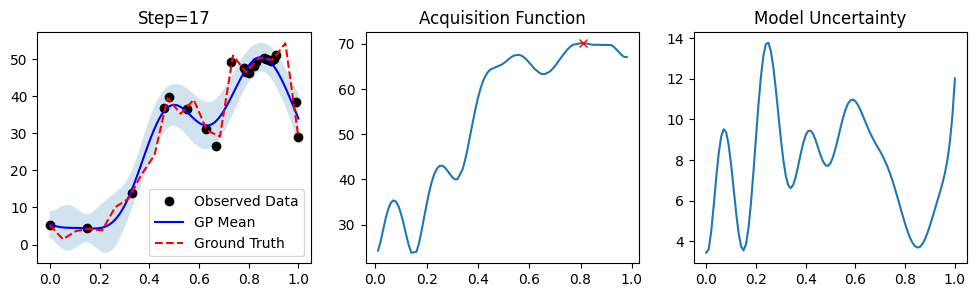

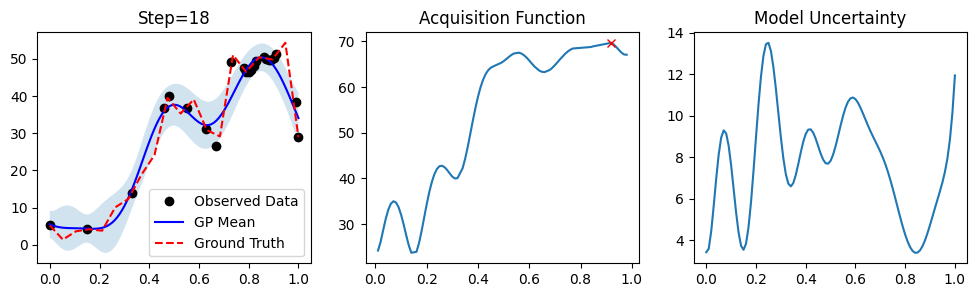

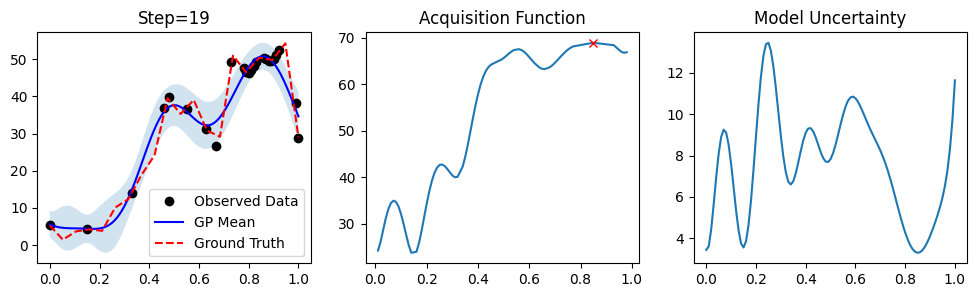

In [22]:
# All codes together

beta = 100 # Pure exploration

# Generate seeding points

X = torch.linspace(0, 1, 101)

np.random.seed(35)

idx = np.random.randint(0, len(X), 5)

X_measured = X[idx]
y_measured = torch.tensor(f_interpolate(X_measured), dtype=torch.float32)
y_var_measured = torch.tensor(noise_interpolate(X_measured), dtype=torch.float32)

X_unmeasured = np.delete(X, idx)

# ------------------------------------------------------------------------------#


num_steps = 20

for step in range(num_steps):
    train_x = X_measured.unsqueeze(-1)
    train_y = torch.tensor(y_measured, dtype = torch.float32).unsqueeze(-1)
    train_yvar = torch.tensor(y_var_measured, dtype = torch.float32).unsqueeze(-1)

    # gp_model = SingleTaskGP(train_x, train_y)
    gp_model = SingleTaskGP(train_x, train_y, train_yvar)

    mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)

    # Fit the model
    fit_gpytorch_mll(mll)

    # Make predictions and plot results
    test_x = torch.linspace(0, 1, 101).unsqueeze(-1)
    gp_model.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred_dist = gp_model.posterior(test_x).mvn
        y_pred = pred_dist.mean
        lower, upper = pred_dist.confidence_region()
        y_sampled = pred_dist.variance

    UCB = UpperConfidenceBound(model=gp_model, beta=beta)
    acq_values = UCB(X_unmeasured.unsqueeze(-1).unsqueeze(-1))

    next_idx = acq_values.argmax()

    next_point = X_unmeasured[next_idx]

    next_measure = f_interpolate(next_point)
    next_var = noise_interpolate(next_point)

    # Plot the results
    clear_output(wait=True)
    fig, ax=plt.subplots(1, 3, figsize=(12, 3))
    ax[0].plot(train_x.numpy(), train_y.numpy(), 'ko', label='Observed Data')
    ax[0].plot(test_x.numpy(), y_pred.numpy(), 'b-', label='GP Mean')
    ax[0].plot(np.linspace(0, 1, 20), amp_mean, 'r--', label='Ground Truth')
    ax[0].fill_between(test_x.squeeze().numpy(), lower.numpy(), upper.numpy(), alpha=0.2)
    ax[0].legend()
    ax[0].set_title('Step={}'.format(step))

    ax[1].plot(X_unmeasured, acq_values.detach().numpy())
    ax[1].plot(X_unmeasured[next_idx], acq_values.detach().numpy()[next_idx], 'rx')

    ax[2].plot(test_x, y_sampled.detach().numpy())
    # ax[2].plot(X_unmeasured[next_idx], y_sampled.detach().numpy()[next_idx], 'rx')
    ax[1].set_title('Acquisition Function')
    ax[2].set_title('Model Uncertainty')

    y_measured = torch.cat((y_measured, torch.from_numpy(np.array([next_measure])).reshape(1)), axis=0)
    y_var_measured = torch.cat((y_var_measured, torch.from_numpy(np.array([next_var])).reshape(1)), axis=0)
    X_measured = torch.cat((X_measured, next_point.reshape(1)), axis=0)
    X_unmeasured = torch.tensor(np.delete(X_unmeasured, next_idx, axis=0), dtype=torch.float32)


# vBO simulation with user-defined priors

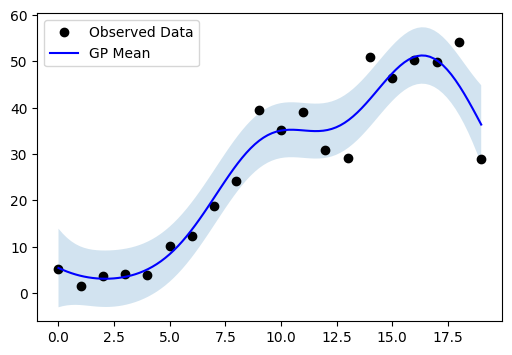

In [23]:
# Define kernel with priors
lengthscale_prior = LogNormalPrior(2, 0.75)
# outputscale_prior = LogNormalPrior(1, 0.75)
# noise_prior = GammaPrior(1, 1)
noise_prior = LogNormalPrior(0.5, 0.5)


train_x = torch.linspace(0, 19, 20,).unsqueeze(-1)
train_y = torch.tensor(amp_mean, dtype = torch.float32).unsqueeze(-1)

kernel = ScaleKernel(RBFKernel(lengthscale_prior=lengthscale_prior), noise_prior=noise_prior)

gp_model = CustomSingleTaskGP(train_x, train_y, kernel=kernel)

mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)

# Fit the model
fit_gpytorch_mll(mll)

# Make predictions and plot results
test_x = torch.linspace(0, 19, 100).unsqueeze(-1)
gp_model.eval()
with torch.no_grad():
    posterior = gp_model.posterior(test_x)
    mean = posterior.mean
    lower, upper = posterior.mvn.confidence_region()

# Plot the results
plt.figure(figsize=(6, 4))
plt.plot(train_x.numpy(), train_y.numpy(), 'ko', label='Observed Data')
plt.plot(test_x.numpy(), mean.numpy(), 'b-', label='GP Mean')
plt.fill_between(test_x.squeeze().numpy(), lower.numpy(), upper.numpy(), alpha=0.2)
plt.legend()
plt.show()

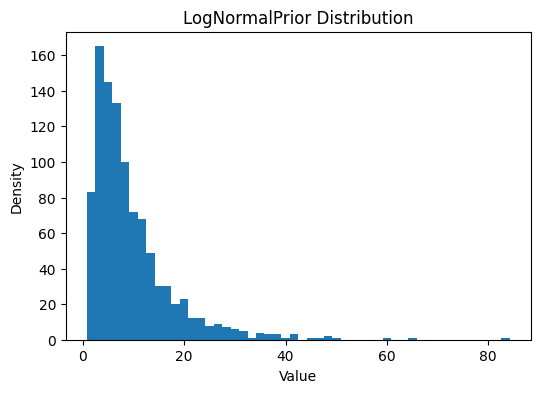

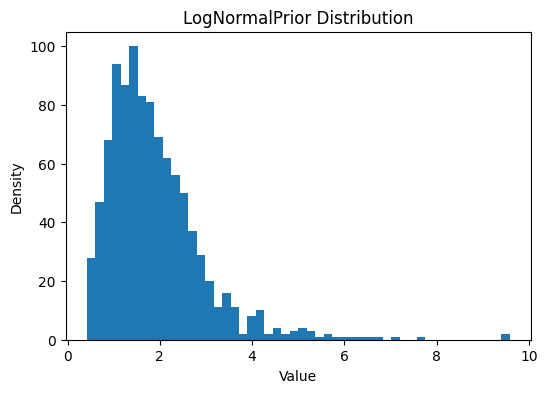

In [24]:
## Visualize the priors

# Define the LogNormalPrior
log_normal_prior = LogNormalPrior(2, 0.75)

# Sample from the LogNormalPrior
samples = log_normal_prior.sample(torch.Size([1000])).numpy()

# Plot the histogram of the samples to visualize the PDF
plt.figure(figsize=(6, 4))
plt.hist(samples, bins=50)
plt.title('LogNormalPrior Distribution')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

# Define the LogNormalPrior
log_normal_prior = LogNormalPrior(0.5, 0.5)

# Sample from the LogNormalPrior
samples = log_normal_prior.sample(torch.Size([1000])).numpy()

# Plot the histogram of the samples to visualize the PDF
plt.figure(figsize=(6, 4))
plt.hist(samples, bins=50)
plt.title('LogNormalPrior Distribution')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()


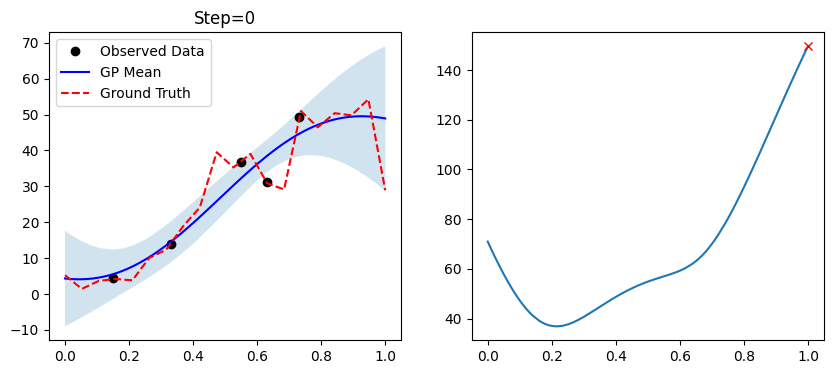

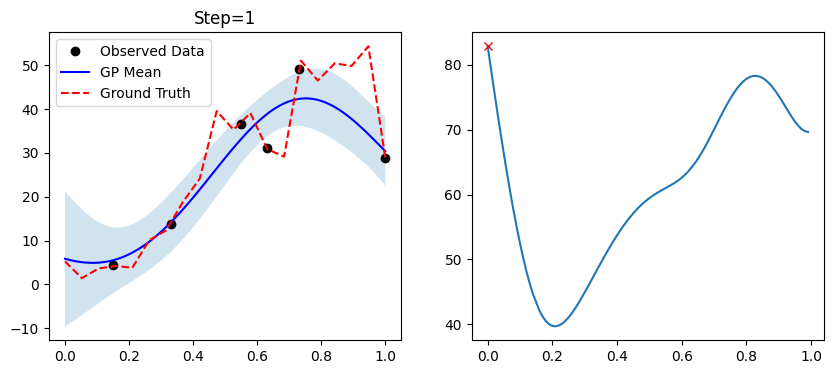

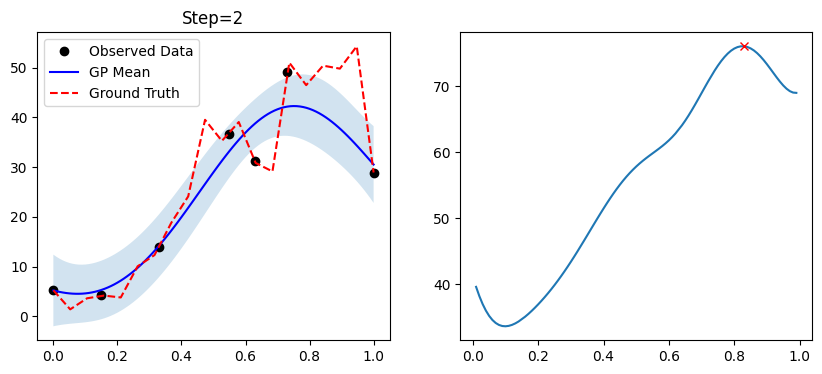

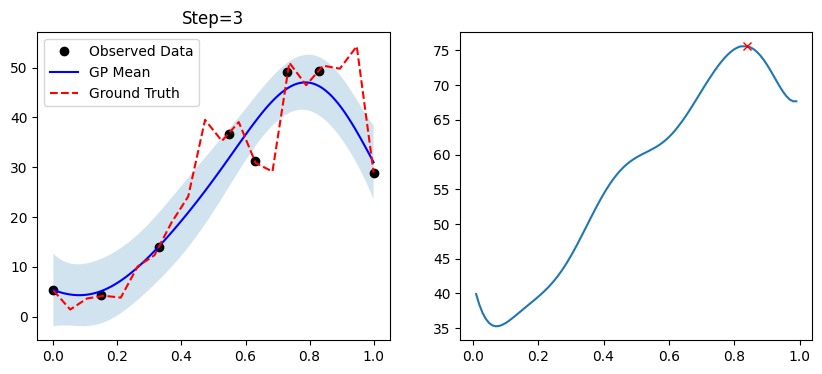

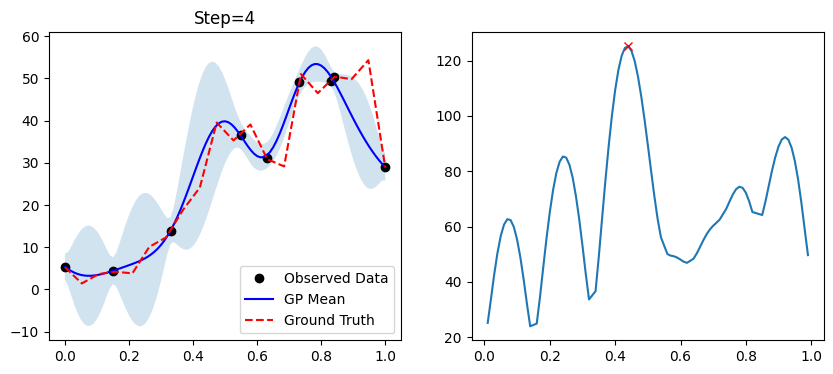

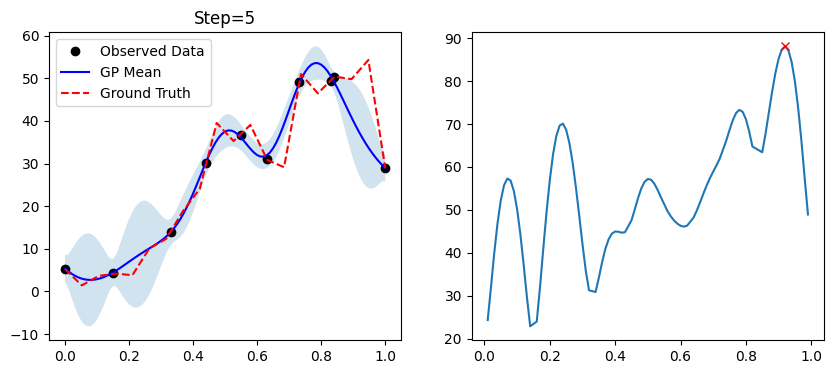

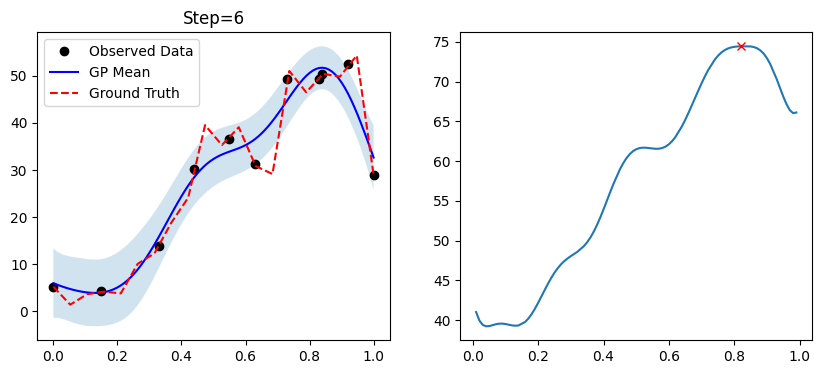

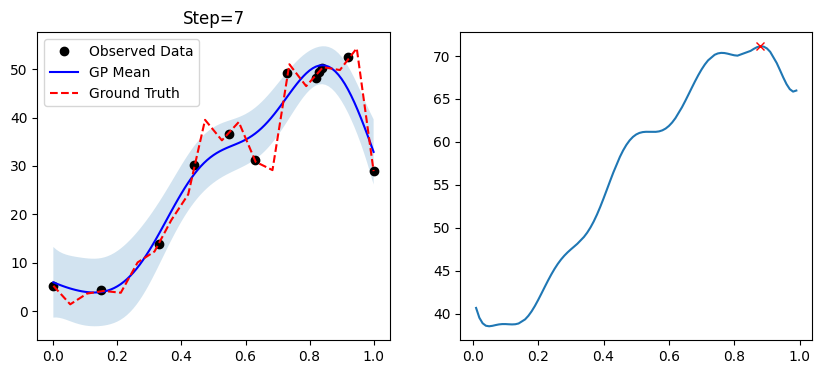

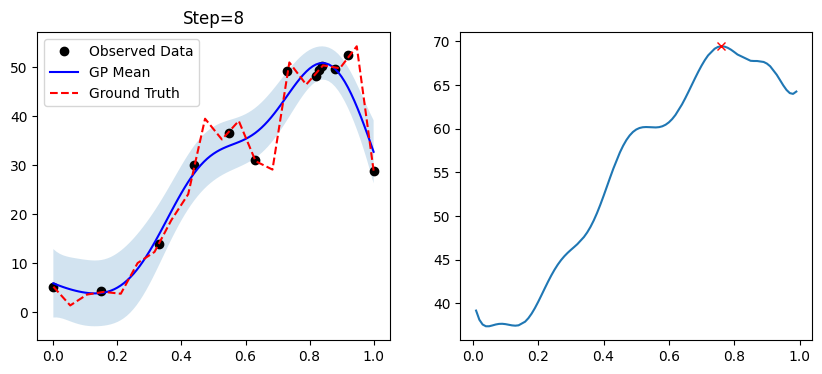

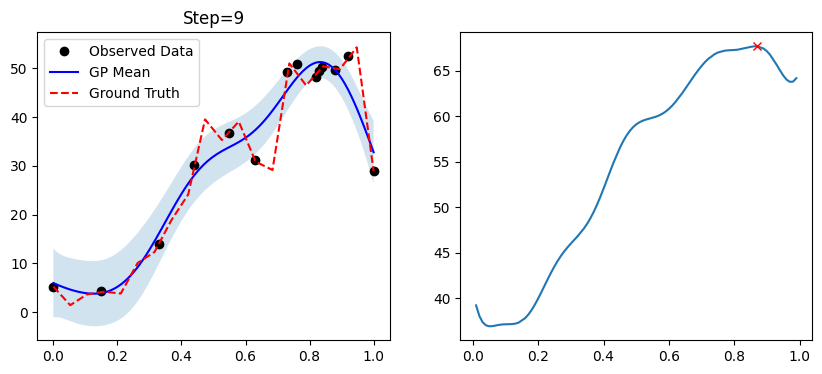

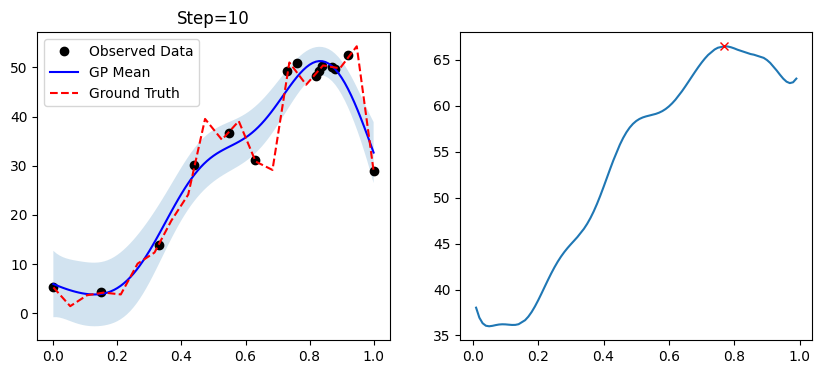

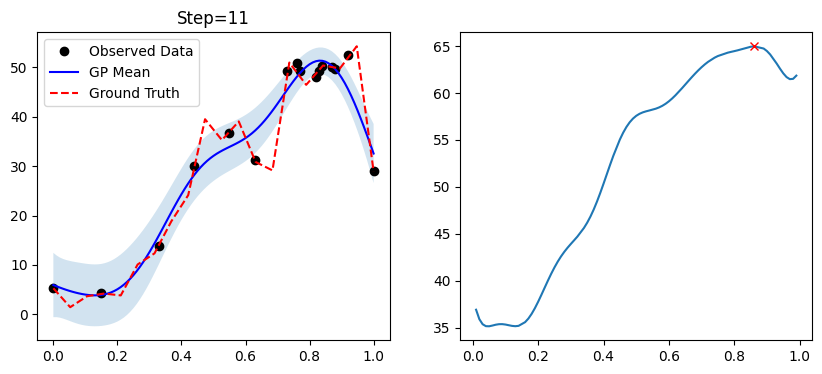

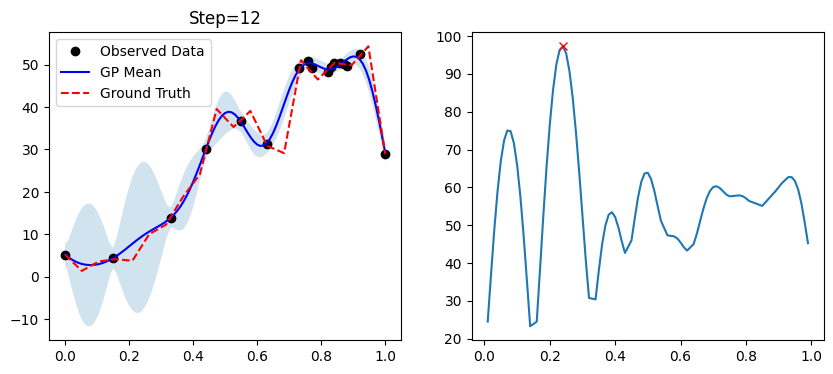

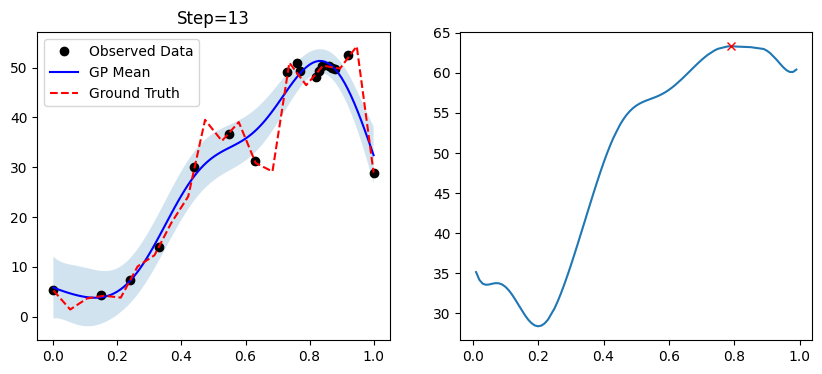

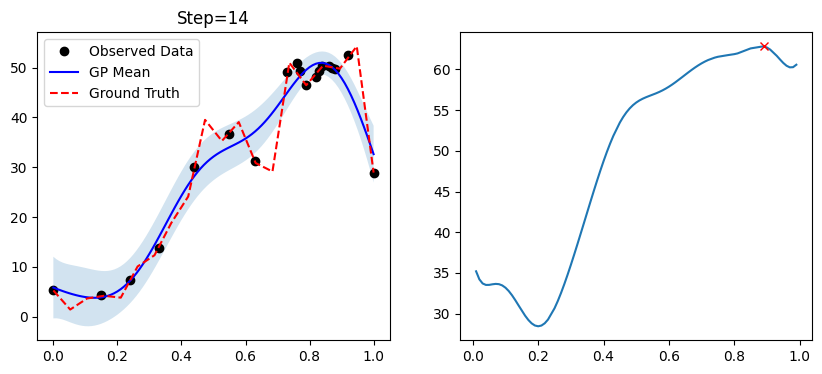

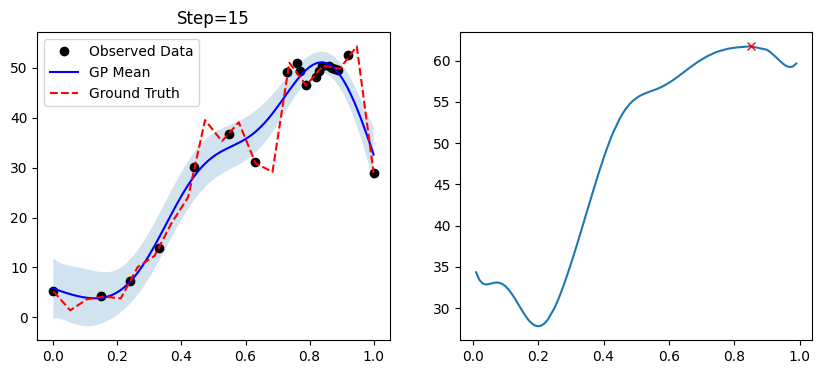

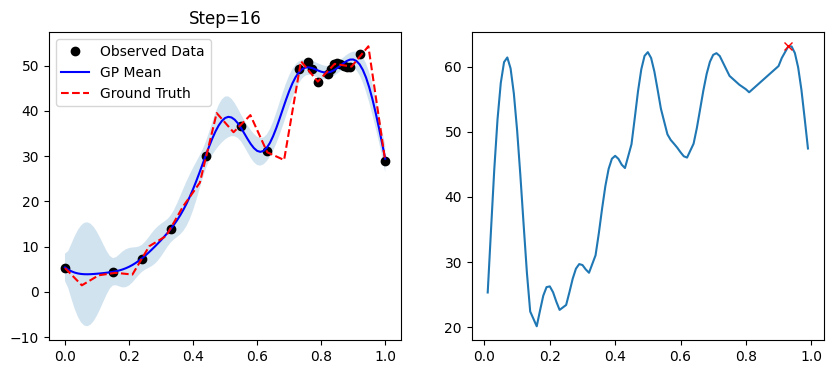

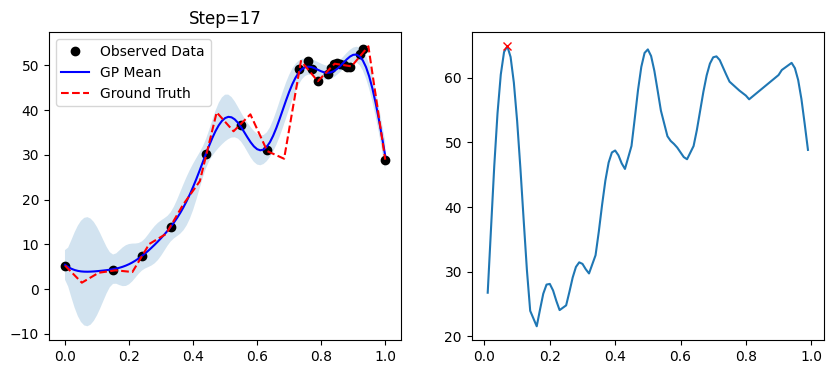

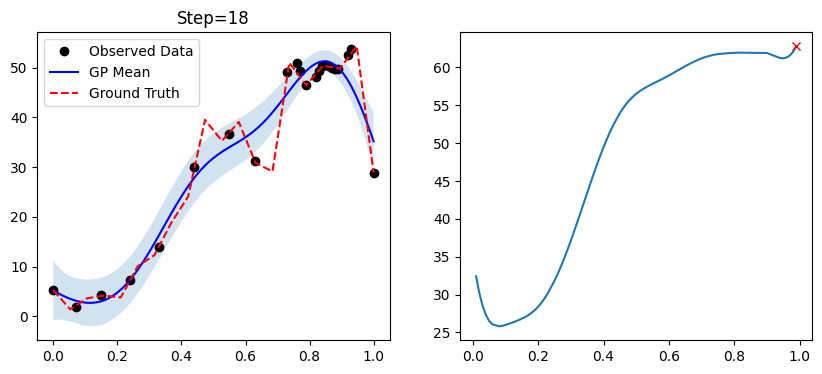

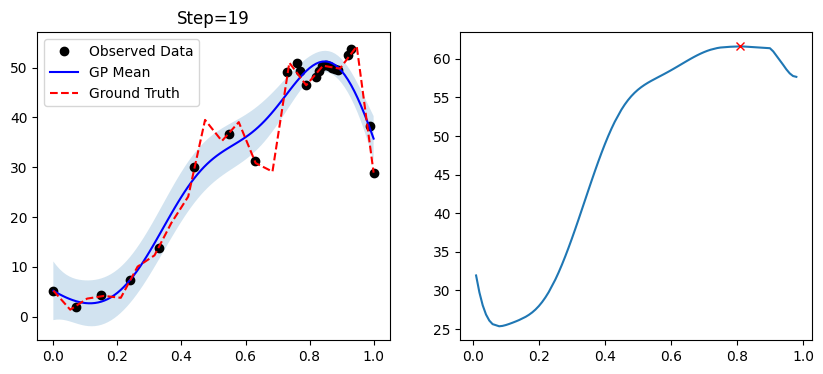

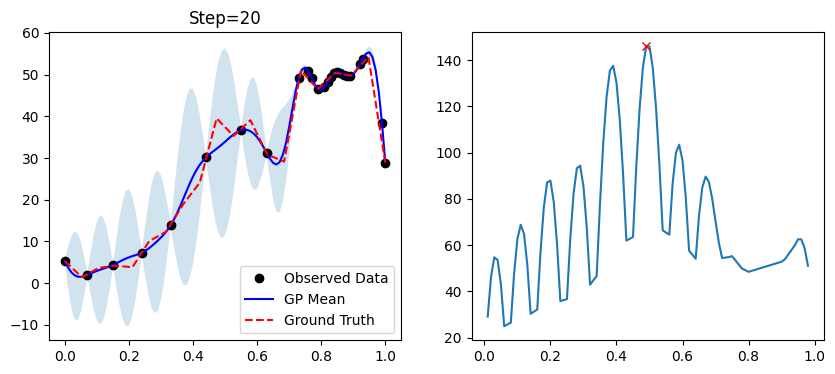

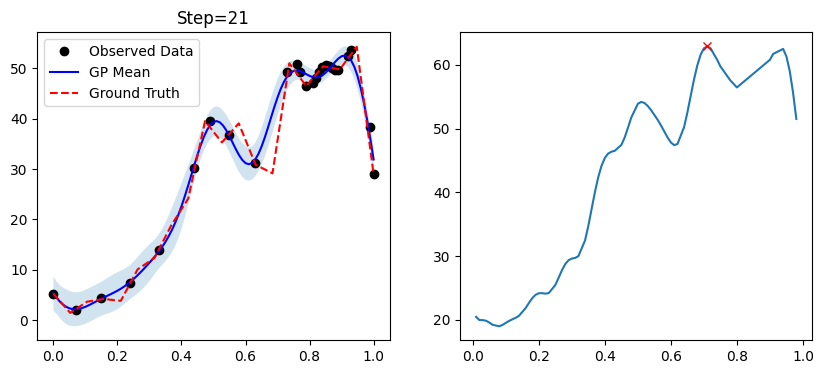

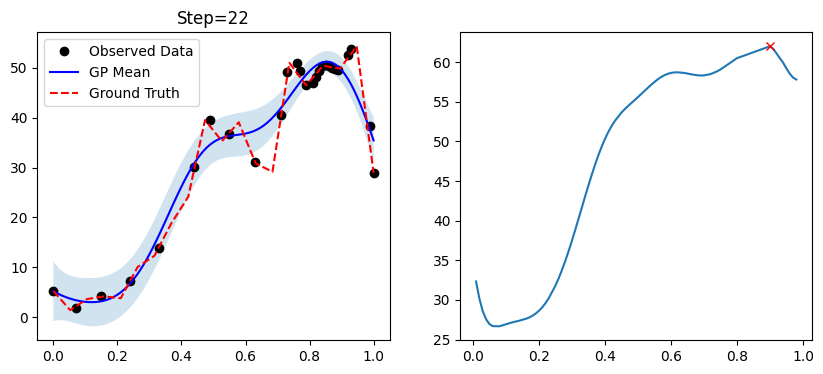

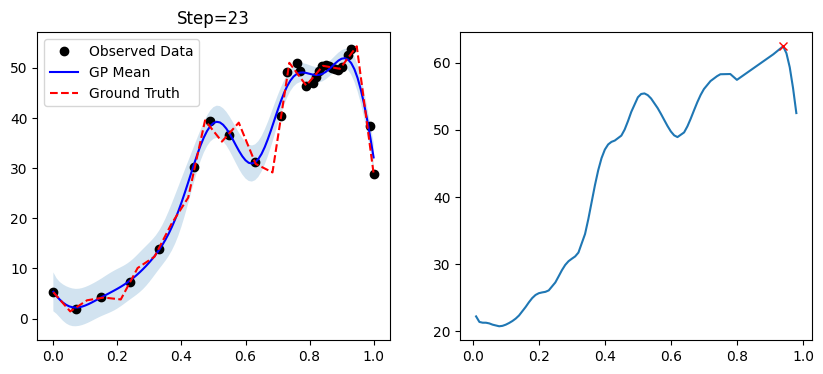

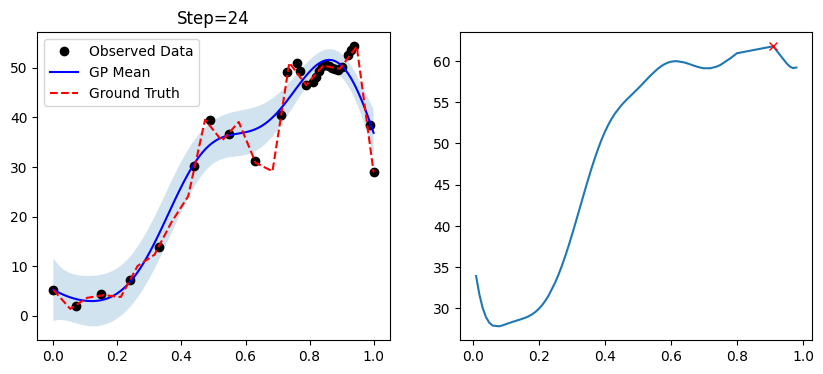

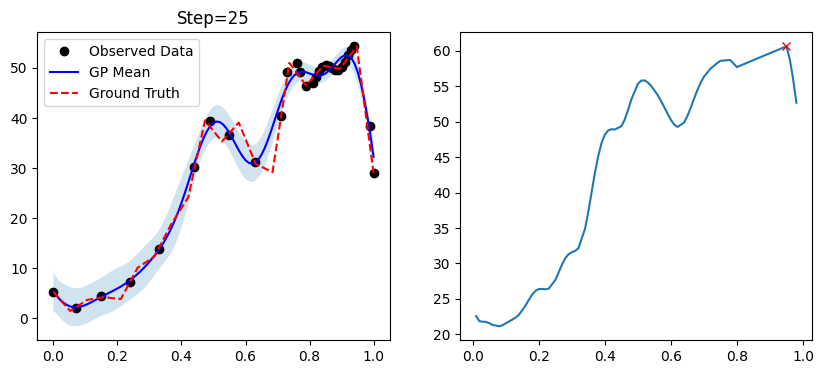

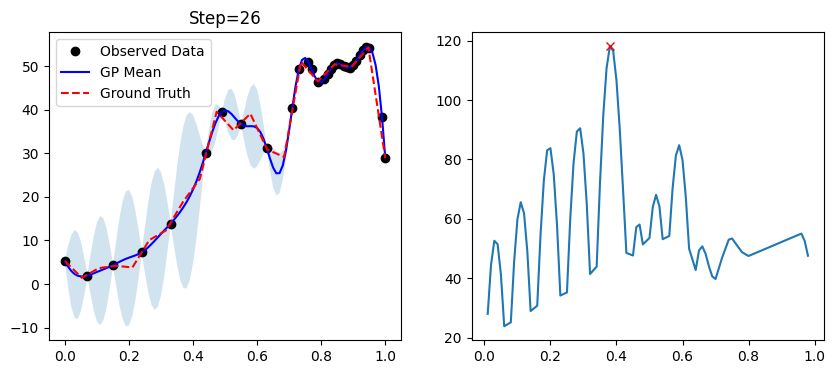

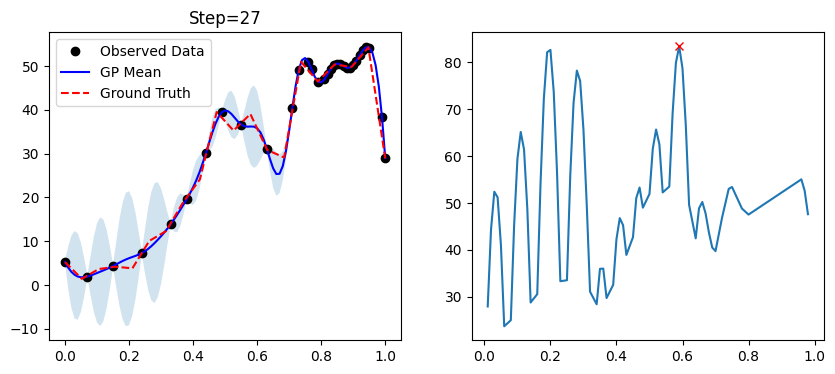

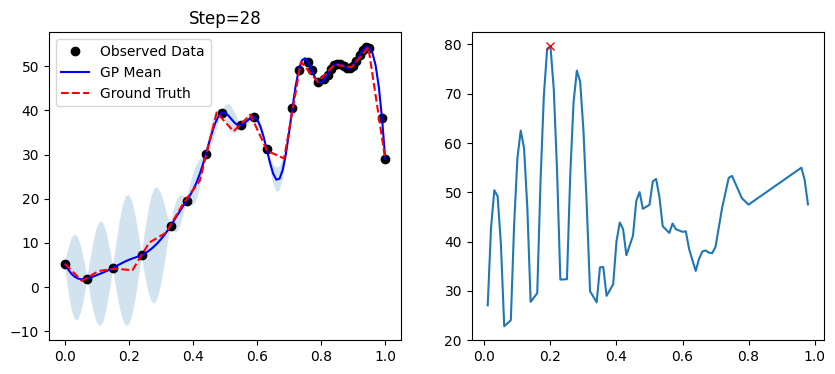

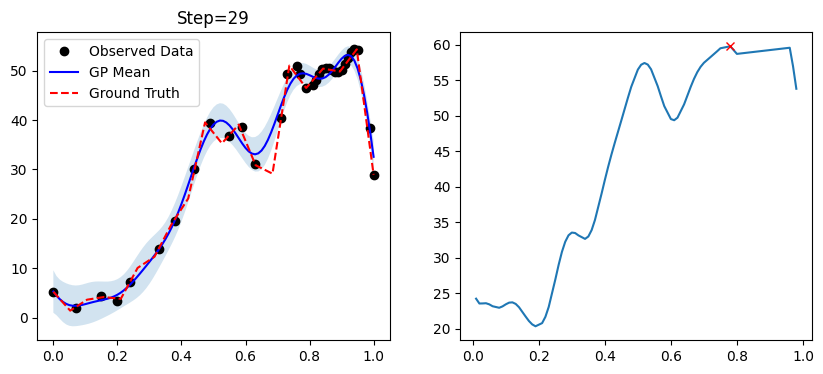

In [25]:
# All codes together

beta = 100 # Pure exploration

# Generate seeding points

X = torch.linspace(0, 1, 101)


np.random.seed(35)

idx = np.random.randint(0, len(X), 5)

X_measured = X[idx]
y_measured = torch.tensor(f_interpolate(X_measured), dtype=torch.float32)

X_unmeasured = np.delete(X, idx)

# ------------------------------------------------------------------------------#

lengthscale_prior = LogNormalPrior(2/10, 0.75/10)
# outputscale_prior = LogNormalPrior(1, 0.75)
# noise_prior = GammaPrior(1, 1)
noise_prior = LogNormalPrior(0.5, 0.5)

num_steps = 30

for step in range(num_steps):
    train_x = X_measured.unsqueeze(-1)
    train_y = torch.tensor(y_measured, dtype = torch.float32).unsqueeze(-1)
    # Please note that here we're not providing the yvar into the model
    # Instead, we rely on the model to estimate the noise by itself

    gp_model = SingleTaskGP(train_x, train_y)
    # gp_model = CustomSingleTaskGP(train_x, train_y, kernel=kernel)
    mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)

    # Fit the model
    fit_gpytorch_mll(mll)

    # Make predictions and plot results
    test_x = torch.linspace(0, 1, 101).unsqueeze(-1)
    gp_model.eval()
    with torch.no_grad():
        posterior = gp_model.posterior(test_x)
        y_pred = posterior.mean
        lower, upper = posterior.mvn.confidence_region()
        y_sampled = posterior.variance.sqrt()

    UCB = UpperConfidenceBound(model=gp_model, beta=beta)
    acq_values = UCB(X_unmeasured.unsqueeze(-1).unsqueeze(-1))

    next_idx = acq_values.argmax()

    next_point = X_unmeasured[next_idx]

    next_measure = f_interpolate(next_point)

    # Plot the results
    clear_output(wait=True)
    fig, ax=plt.subplots(1, 2, figsize=(10, 4))
    ax[0].plot(train_x.numpy(), train_y.numpy(), 'ko', label='Observed Data')
    ax[0].plot(test_x.numpy(), y_pred.numpy(), 'b-', label='GP Mean')
    ax[0].plot(np.linspace(0, 1, num=20), amp_mean, 'r--', label='Ground Truth')
    ax[0].fill_between(test_x.squeeze().numpy(), lower.numpy(), upper.numpy(), alpha=0.2)
    ax[0].legend()
    ax[0].set_title('Step={}'.format(step))

    ax[1].plot(X_unmeasured, acq_values.detach().numpy())
    ax[1].plot(X_unmeasured[next_idx], acq_values.detach().numpy()[next_idx], 'rx')

    y_measured = torch.cat((y_measured, torch.from_numpy(np.array([next_measure])).reshape(1)), axis=0)
    X_measured = torch.cat((X_measured, next_point.reshape(1)), axis=0)
    X_unmeasured = torch.tensor(np.delete(X_unmeasured, next_idx, axis=0), dtype=torch.float32)
